In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pycountry
import pickle
import us

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 

from gensim.models import Word2Vec

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

%matplotlib inline

%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets_processed = pd.read_csv("tweets_likhitha_processed.csv", parse_dates=["Created at"])


In [3]:
print("Since:",tweets_processed["Created at"].min())

# Print the maximum datetime
print("Until",tweets_processed["Created at"].max())

Since: 2021-03-25 00:21:14
Until 2021-03-30 23:18:42


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


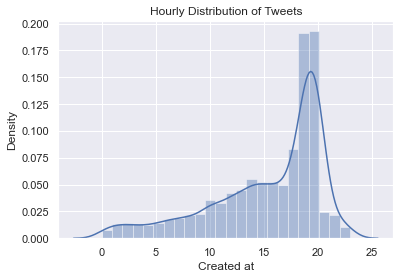

In [4]:
sns.set()

# Plot the histogram of hours
sns.distplot(tweets_processed["Created at"].dt.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

In [5]:

# Print the value counts of Country column
print(tweets_processed["Country"].value_counts())

unknown    7779
US          207
GB          188
CA           68
ES           68
           ... 
LI            1
TJ            1
KY            1
LS            1
BM            1
Name: Country, Length: 70, dtype: int64


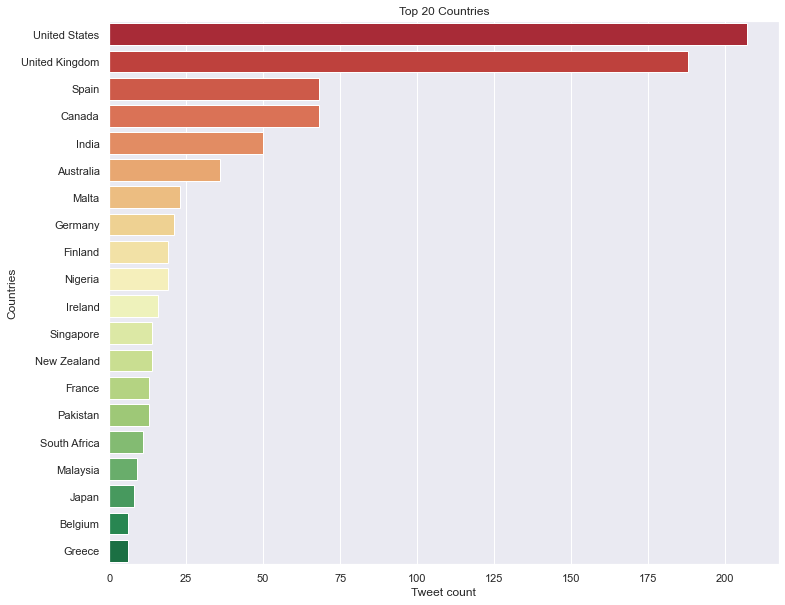

In [6]:
countries = tweets_processed[tweets_processed.Country!='unknown']

# Select the top 20 countries
top_countries = countries["Country"].value_counts(sort=True).head(20)

# Convert alpha2 country codes to country names and store in a list
country_fullnames = []
for alpha2 in top_countries.index:
    country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.barplot(y=country_fullnames,x=top_countries, orient="h", palette="RdYlGn")
plt.xlabel("Tweet count")
plt.ylabel("Countries")
plt.title("Top 20 Countries")
plt.show()

In [7]:
display(tweets_processed.sort_values(by=["Favorites","Retweet-Count", ], axis=0, ascending=False)[["Content","Retweet-Count","Favorites"]].head(20))

,Content,Retweet-Count,Favorites
2472,"Just heard a ""leftist"" say ""radical change is off the table bc Bernie didn't win."" \n\nIf you believe this, why did you pressure folks to vote for Biden using the climate crisis as leverage? You know it's going to take radical change to remedy, right?",171,1427
2546,"Alex Sobel correctly describes corporations as ""the enemy"" when it comes to climate change, then has to apologise to Keir Starmer. What a pathetic leadership.\n\n""He's apologised to me. The Labour Party, under my leadership, is very clearly pro-business.""\nhttps://t.co/9ZSF5lGUDz",143,510
7829,"@high_currency @CourtneeHendrix This is like global warming opponents. You read and listen to the ones that are actual experts and publish well received peer reviewed papers etc, and go with the vast majority of *serious* experts in their field.",9,508
2128,Douglas Ross won’t even work with the SNP on climate change. A leader? I think not. #BBCLeadersDebate,104,495
5092,oh god oh fuck I’m in an environment,47,363
1988,"Important point by @NicolaSturgeon that, contrary to popular portrayals, parties do actually work together. Over the last Parliament, we have worked across party lines on mental health, period poverty and climate change to name just a few. #leadersdebate",76,329
6492,In wake of #Globalwarming &amp; #ClimateChange The world's most Visionary Leader is PM #ImranKhan who not only took practical steps to contribute into improving/conserving greenforests but has also sensitized the sleeping world \nHis speeches can be used by newcomer @JoeBiden @POTUS https://t.co/cGn4rrIhKl,116,296
8294,"1970’s-New Ice Age\n\n1980’s-Acid Rain\n\n1990’s-Ozone Depletion \n\n2000-Global Warming \n\n2010-switch to Climate Change because the globe was no longer warming\n\n40+ years of baseless fear mongering to rip off billions from taxpayers, expand gov power, and advance the left’s agenda",269,267
1215,What if two cabinet ministers and two guests hosted a zoom news conference and nobody showed up? Subject: carpooling for #climatechange. From March 29 transcript. 1/3 #cdnpoli https://t.co/twPjCTPFtT,99,239
2446,"""Don't worry, we'll only use vaccine passports to fight this one terrible epidemic,"" say people who have explicitly stated gun violence, climate change, and white supremacy are epidemics every bit as serious as the coronavirus and should be fought with the same techniques.",74,206


In [38]:
tfidf_stops = ["environment", "leftist", "activist", "globalwarming", "warming",
               "climate", "change", "climatechange", "global", "green",
               "greenhouseeffect", "gas", "emission","pollute","pollution",
               "tree", "gas", "green", "eco", "ecofriendly",
               "initiatives", "support", "protect", "serious", "ban",
               "carbon", "shark", "crisis", "fight", "goal",
               "leadership","future", "pollution", "temperature", "temp",
               "atmosphere", "environmental", "drought", "emisson", "shark",
                "loss", "hurricanes", "weather", "warm", "warming",
               "sea", "sealevel", "ocean", "production", "rises",
               "rising","tax", "fight", "heat", "air",
               "oil", "zero", "waste", "gasoline", "dying",
               "urgent", "hot","reduce", "combat", "address",
                "education", "climateaction","activist", "tackle", "tree",
               "dioxiode", "plant", "technology", "scientists","adapt",
               "sustainability","electric", "car", "suv", "power",
               "economists", "harm", "harmful", "absorb", "denial",
               "climateaction", "solar", "ecosystems", "soil", "consequences",
               "nations", "cities", "flooding","arctic", "wind", 
               "world", "cut", "cutdown", "crisis", "climatecrisis",
               "clean", "cleanenergy", "growth", "water", "wildfire",
               "ecofriendly", "renewable", "renewableenergy", "cherry", "blossom", 
               "harmful", "agriculture", "vulnerable", "biodiversity", "zerowaste"]

# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=115, stop_words= tfidf_stops)

#m = tweets_processed["Processed"].apply(lambda x: ' '.join(x))
# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"].values.astype('U'))

# Let's see what we have
display(tfidf_matrix)

# Create a DataFrame for tf-idf vectors and display the first five rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

<8684x115 sparse matrix of type '<class 'numpy.float64'>'
	with 20472 stored elements in Compressed Sparse Row format>

,action,also,amp,around,back,bad,bbcleadersdebate,believe,biden,big,...,use,via,want,way,well,work,working,would,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total frequency'])

# Sort the words by frequency
frequencies.sort_values(by='total frequency',ascending=False, inplace=True)
# Display the most 20 frequent words
display(frequencies.head(20))

,total frequency
amp,371.688489
new,271.387588
people,250.519904
like,221.646306
one,187.544857
good,179.789856
energy,179.234932
via,175.654159
work,169.054827
time,165.350966


In [40]:
#Sentiment Analysis

In [41]:
def remove_floats(row):
  if isinstance(row, str):
    return row
  else:
    return None

for key in tweets_processed:
  tweets_processed["Processed"] =tweets_processed["Processed"] .apply(remove_floats)
tweets_processed.dropna(inplace=True)

m=tweets_processed["Processed"]
tweets_processed["Polarity"] = m.apply(lambda word: TextBlob(word).sentiment.polarity)
tweets_processed["Subjectivity"] = m.apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(tweets_processed[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,0.000,0.000000
1,0.000,0.000000
2,0.000,0.000000
3,0.300,0.375000
4,0.200,0.200000
5,0.375,1.000000
6,0.000,0.000000
7,-0.150,0.133333
8,0.000,0.000000
9,0.000,0.000000


In [42]:
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
tweets_processed["Label"] = tweets_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(tweets_processed[["Label"]].head(10))

,Label
0,Neutral
1,Neutral
2,Neutral
3,Positive
4,Positive
5,Positive
6,Neutral
7,Negative
8,Neutral
9,Neutral


In [43]:
print(tweets_processed["Label"].value_counts())

Positive    4048
Neutral     2639
Negative    1997
Name: Label, dtype: int64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


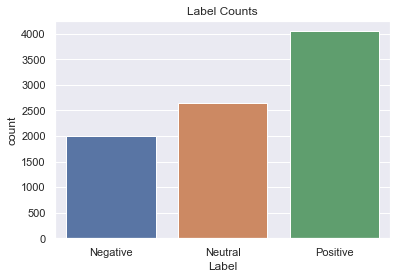

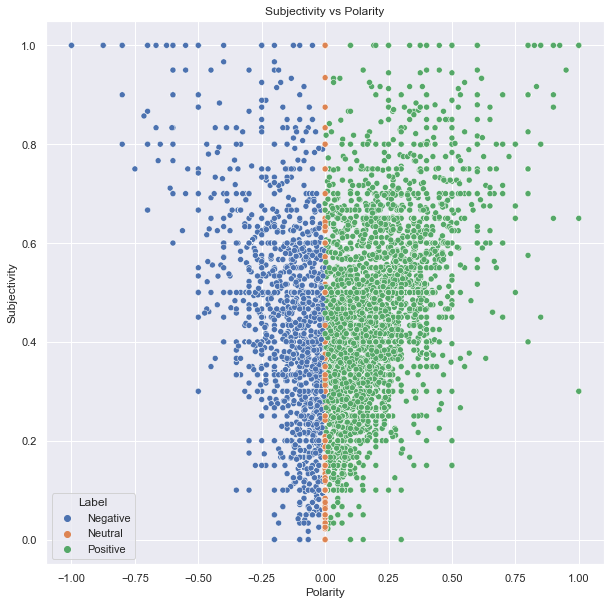

In [44]:
tweets_processed["Label"] = tweets_processed["Label"].astype("category")

# Visualize the Label counts
sns.countplot(tweets_processed["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)
plt.title("Subjectivity vs Polarity")
plt.show()


In [45]:
display(tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
980,"@PaprikaLady Perfect timing, anonymous one. I rest my case.\n\n#ClimateBrawl #ClimateCrisis #climatechange",1,5,1.0
6582,"And because i am fed up of moronic liar #Biden\n\n#America also oozing a ton of #CO2 and methane\nPerfect timing for 5 trillions #stimulus\nbecause he ""follows the science"" \n\nFACTS ON THE GROUND\n\n25.03.2021\n#ClimateCrisis #climatechange #globalwarming #NetZero https://t.co/TVoC7jsirY",0,5,1.0
7135,"One of the best benefits of using solar outdoor lights is cost-effectiveness. The moment you see a decrease in your electricity bill, you will realize that these lights pay for themselves.\n#ecofriendly #sustainability #climatechange #globalwarming https://t.co/ASlX7GkcWa",0,4,1.0
2374,"Wonderful writeup on @IReadJotwell by @MiriamSeifter of ""Rethinking Grid Governance for the Climate Change Era,"" forthcoming in the @callawreview by @shelley_welton (@UofSCLaw): https://t.co/D19UriRaP9",2,3,1.0
115,@Crowers21 @cco8226 Don't care what he refers to... the blog is a junk site... perfect for climate deniers though\n\n#ClimateBrawl #ClimateCrisis #climatechange,1,3,1.0
1460,Looks like an excellent addition to #climatechange #education @benking01 @geography_paul https://t.co/biP2xfDCZh,0,3,1.0
6385,"#America also oozing a ton of #methane\nPerfect timing for 5 trillions #stimulus\nbecause we ""follow the science"" \n\n26.03.2021\n#ClimateCrisis #climatechange #globalwarming #NetZero https://t.co/DMufH4kQmW",0,3,1.0
270,"The SNP keep setting targets but then miss them, they are excellent at that @Douglas4Moray #bbcleadersdebate @ScotTories #leadersdebate #climatechange",1,2,1.0
872,"@aries_project A2: We are in an #EcologicalCrisis. The best thing humans can do is to preserve #biodiversity, because it’s the best “technology”.\n\n#AriesChat #ClimateChange #ClimateCrisis #BiodiversityCrisis",1,2,1.0
7146,This could be a perfect metaphor to the amount resources the world is committing to fight something like #GlobalWarming or #pollution 😅 https://t.co/R497SC3W6l,1,2,1.0


,Content,Retweet-Count,Favorites,Polarity
2010,Douglas Ross refusing to work with the Scottish Government to tackle climate change. Shocking that a mainstream party can’t put the environment above the constitution #BBCLeadersDebate,17,40,-1.0
5547,The SNP are on course to miss another targetr with their flagship recycling pledge. They don’t deliver on the environment. Their record on protecting our biodiversity is shocking #LeadersDebate,1,7,-1.0
1107,"The $1,599 Varla Eagle One Electric Scooter Packs Insane Power &amp; Range (CleanTechnica Review) https://t.co/UZIfsbApFa #Tesla #EV #ClimateChange #Renewables #RenewableEnergy",2,2,-1.0
6868,This will probably be a terrible year for #wildfires #globalwarming https://t.co/IPZCu4jvgI,1,2,-1.0
5856,Shocking floods in Cali Colombia 2021 The power of nature https://t.co/0Ln5L8YPh2 via #YouTube \n\n#Columbia #floods #Cali #climate #ClimateStrike #news #latestnews #latestnewstoday #ClimateAction #GlobalWarming,1,1,-1.0
6419,US Fossil Fuel Companies Get a Shocking Amount of Implicit Subsidies Each Year\n#GlobalWarming #subsidies https://t.co/764m1gekb1,1,1,-1.0
2215,"@spectaovreurope The context of the comments makes this even grimmer, considering he was talking about combatting climate change.",0,1,-1.0
465,Australia is a terrifying preview of a world ravaged by #climatechange. #ClimateAction #ClimateTwitter #ClimateCrises | @DebHaalandNM @RepDebHaaland @Interior | https://t.co/cjaf7EJAxY,1,0,-1.0
226,Fracking is terrible like oil drilling is! #stopFracking #FuckFracking #FrackingFuckingSucks #FFS #climatechange,0,0,-1.0
1584,@AndrewBowie_MP Not even on climate change? Pathetic.,0,0,-1.0


Positive 

Country
GB    43
US    40
ES    21
CA    17
IN     9
AU     7
MT     7
NZ     5
DE     4
FI     3
GR     3
SG     3
NO     2
BD     2
FR     2
IT     2
JP     2
MY     2
PH     2
ZA     2
RO     2
NP     1
IL     1
NL     1
MV     1
LI     1
KH     1
JO     1
IS     1
HK     1
IE     1
CN     1
BM     1
BE     1
AT     1
AR     1
AQ     1
QA     1
Name: Country, dtype: int64

Negative

Country
GB    100
US     92
CA     35
ES     32
AU     20
IN     18
MT     16
DE     11
PK      9
IE      9
FR      8
NZ      6
FI      5
MY      5
NG      5
ZA      4
BE      3
SG      3
IT      2
AQ      2
CL      2
GR      2
HK      2
JM      2
QA      2
SA      2
TH      2
ZW      2
KE      2
UA      1
KY      1
TR      1
RO      1
PT      1
PH      1
NO      1
MX      1
LU      1
CV      1
JP      1
GH      1
BR      1
BG      1
BD      1
AT      1
AE      1
UG      1
Name: Country, dtype: int64


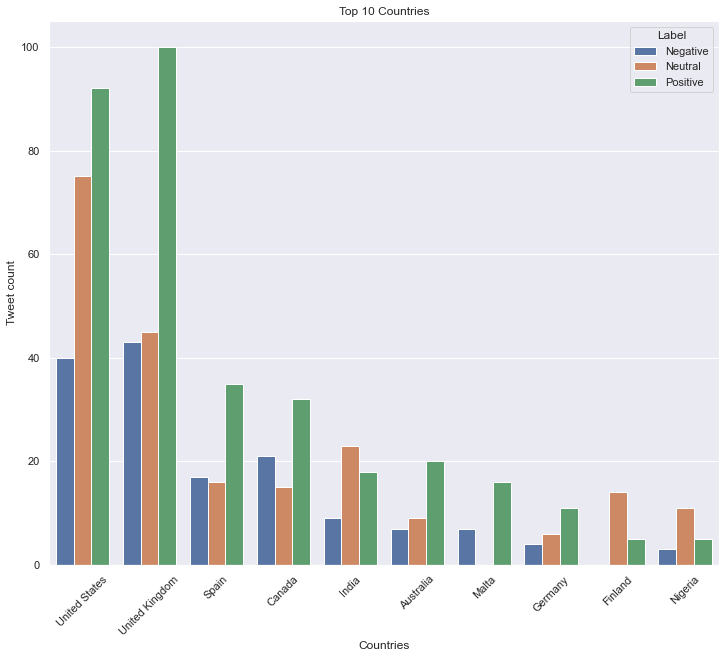

In [46]:
positives_by_country = tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Negative.sort_values(ascending=False)
negatives_by_country =tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Positive.sort_values(ascending=False)

# Print them out
print("Positive \n")
print(positives_by_country)
print("\nNegative\n")
print(negatives_by_country)

# Create a mask for top 1 countries (by tweets count)
mask = tweets_processed["Country"].isin(top_countries.index[:10]).values

# Create a new DataFrame only includes top10 country
top_20df = tweets_processed.iloc[mask,:]

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.countplot(x="Country", hue="Label", data=top_20df, order=top_20df["Country"].value_counts().index)
plt.xlabel("Countries")
locs, labels = plt.xticks()
plt.xticks(locs, country_fullnames[:10])
plt.xticks(rotation=45)
plt.ylabel("Tweet count")
plt.title("Top 10 Countries")
plt.show()

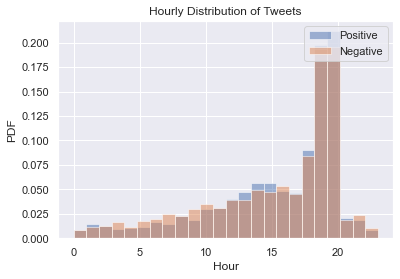

In [47]:
positive = tweets_processed.loc[tweets_processed.Label=="Positive"]["Created at"].dt.hour
negative = tweets_processed.loc[tweets_processed.Label=="Negative"]["Created at"].dt.hour

plt.hist(positive, alpha=0.5, bins=24, label="Positive", density=True)
plt.hist(negative, alpha=0.5, bins=24, label="Negative", density=True)
plt.xlabel("Hour")
plt.ylabel("PDF")
plt.title("Hourly Distribution of Tweets")
plt.legend(loc='upper right')
plt.show()

In [19]:
# it seems like there's no relationship between time tweeted and polarity

In [20]:
#Build a model


In [48]:
le = LabelEncoder()
tweets_processed["Label_enc"] = le.fit_transform(tweets_processed["Label"])

# Display the encoded labels
display(tweets_processed[["Label_enc"]].head())

# Select the features and the target
X = tweets_processed['Processed']
y = tweets_processed["Label_enc"]

,Label_enc
0,1
1,1
2,1
3,2
4,2


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)


In [50]:
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.6206896551724138


In [52]:
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[ 97 165 137]
 [ 29 393 106]
 [ 57 213 540]]


Classification Report

              precision    recall  f1-score   support

           0       0.53      0.24      0.33       399
           1       0.51      0.74      0.61       528
           2       0.69      0.67      0.68       810

    accuracy                           0.59      1737
   macro avg       0.58      0.55      0.54      1737
weighted avg       0.60      0.59      0.58      1737



In [41]:

# Save the model
pickle.dump(nb, open("climate_model.pkl", 'wb'))

In [39]:
tweets_processed.to_csv("climate_sentiments.csv")